MIT License

Copyright (c) Microsoft Corporation. All rights reserved.

This notebook is adapted from [Francesca Lazzeri Energy Demand Forecast Workbench workshop](https://github.com/FrancescaLazzeri/EnergyDemandForecastWorkbench).

Copyright (c) 2021 PyLadies Amsterdam, Alyona Galyeva


# Data preparation
Run this notebook to prepare the data for modelling and registering prepared datasets.

**Important prerequisites**: 
- Change the kernel to Python 3.8.10...('mlops_train':conda) You can do this from the *Kernel* menu under *Change kernel*.

Run each cell of this notebook to perform the following steps:
- Import the data from csv files and merge the two datasets.
- The data is cleaned by filling gaps in the time series and handling missing values.
- The data is explored through visualisation.
- Features for the forecasting models are computed.
- Data is split into training and test sets.
- Connect to Azure Machine learning workspace and register processed, train, test datasets

In [1]:
%matplotlib inline
import os
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from azureml.core import Workspace, Dataset
from pandas.plotting import autocorrelation_plot
from scipy import stats

### Load energy demand data and merge with weather data

In [3]:
WORKDIR = os.getcwd()
DATADIR = os.path.join(WORKDIR, 'datasets')

In [4]:
demand_raw = pd.read_csv(os.path.join(DATADIR,'nyc_demand_raw.csv'), parse_dates=['timeStamp'])
weather_raw = pd.read_csv(os.path.join(DATADIR,'nyc_weather_raw.csv'), parse_dates=['timeStamp'])
demand = pd.merge(demand_raw, weather_raw, on=['timeStamp'], how='outer')
demand['demand'] = demand['demand'].astype(float)
demand.head()

,timeStamp,demand,precip,temp
0,2012-01-01 00:00:00,4937.5,0.0,46.13
1,2012-01-01 01:00:00,4752.1,0.0,45.89
2,2012-01-01 02:00:00,4542.6,0.0,45.04
3,2012-01-01 03:00:00,4357.7,0.0,45.03
4,2012-01-01 04:00:00,4275.5,0.0,42.61


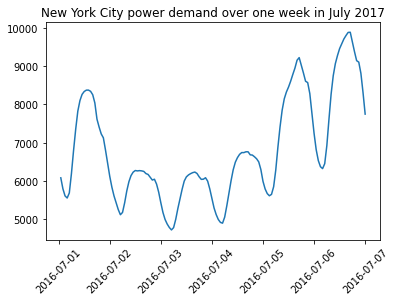

In [5]:
plt_df = demand.loc[(demand.timeStamp>'2016-07-01') & (demand.timeStamp<='2016-07-07')]
plt.plot(plt_df['timeStamp'], plt_df['demand'])
plt.title('New York City power demand over one week in July 2017')
plt.xticks(rotation=45)
plt.show()

### Fill gaps in the time series

Some periods in the time series are missing. This occurs if the period was missing in both the original demand and weather datasets. To identify these gaps, first we create an index of time periods that we would *expect* to be in the time series. There should be one record for every hour between the minimum and maximum datetimes in our dataset.

In [6]:
min_time = min(demand['timeStamp'])
min_time

Timestamp('2012-01-01 00:00:00')

In [9]:
max_time = max(demand['timeStamp'])
max_time

Timestamp('2017-08-12 06:00:00')

In [10]:
dt_idx = pd.date_range(min_time, max_time, freq='H')
dt_idx

DatetimeIndex(['2012-01-01 00:00:00', '2012-01-01 01:00:00',
               '2012-01-01 02:00:00', '2012-01-01 03:00:00',
               '2012-01-01 04:00:00', '2012-01-01 05:00:00',
               '2012-01-01 06:00:00', '2012-01-01 07:00:00',
               '2012-01-01 08:00:00', '2012-01-01 09:00:00',
               ...
               '2017-08-11 21:00:00', '2017-08-11 22:00:00',
               '2017-08-11 23:00:00', '2017-08-12 00:00:00',
               '2017-08-12 01:00:00', '2017-08-12 02:00:00',
               '2017-08-12 03:00:00', '2017-08-12 04:00:00',
               '2017-08-12 05:00:00', '2017-08-12 06:00:00'],
              dtype='datetime64[ns]', length=49207, freq='H')

Now we index the dataframe according to this datetime index to insert missing records into the time series:

In [11]:
demand.index = demand['timeStamp']
demand = demand.reindex(dt_idx)

Inserted missing records will have NaN/NaT values for all columns:

In [12]:
demand[demand.isnull().all(axis=1)]

,timeStamp,demand,precip,temp
2016-03-13 02:00:00,NaT,NaN,NaN,NaN
2017-03-12 02:00:00,NaT,NaN,NaN,NaN


Now that there are no missing periods in the time series, we can start handling missing values by filling as many many as possible. Firstly, count the number of missing values in each column:

In [13]:
demand.isnull().sum()

timeStamp      2
demand        83
precip       232
temp         188
dtype: int64

Missing timeStamp can be filled from the dataframe index:

In [14]:
demand.loc[demand.isnull().all(axis=1), 'timeStamp'] = demand.loc[demand.isnull().all(axis=1)].index

For the other columns, we can fill many missing values by interpolating between the two closest non-missing values. Here, we use a quadratic function and set a limit of 6. This limit means that if more than 6 missing values occur consecutively, the missing values are not interpolated over and they remain missing. This is to avoid spurious interpolation between very distant time periods.

In [16]:
demand = demand.interpolate(limit=6, method='ffill')

Fill missing precip values with common value of 0:

In [17]:
precip_mode = np.ndarray.item(stats.mode(demand['precip']).mode)
demand['precip'] = demand['precip'].fillna(precip_mode)

In [18]:
demand.isnull().sum()

timeStamp     0
demand       43
precip        0
temp         86
dtype: int64

The number of missing values has now been greatly reduced. Records containing the remaining missing values will be removed later after model features have been created.

### Explore the data

By visualising the data, we can gain some intuition as to what kind of features could be helpful to the model.

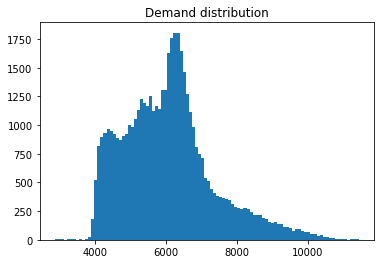

In [19]:
plt.hist(demand['demand'].dropna(), bins=100)
plt.title('Demand distribution')
plt.show()

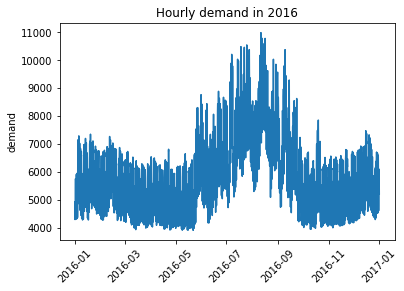

In [20]:
plt_df = demand.copy().loc[(demand['timeStamp']>='2016-01-01') & (demand['timeStamp']<'2017-01-01'), ]
plt.plot(plt_df['timeStamp'], plt_df['demand'], markersize=1)
plt.title('Hourly demand in 2016')
plt.ylabel('demand')
plt.xticks(rotation=45)
plt.show()

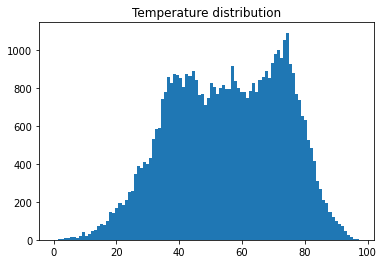

In [21]:
plt.hist(demand['temp'].dropna(), bins=100)
plt.title('Temperature distribution')
plt.show()

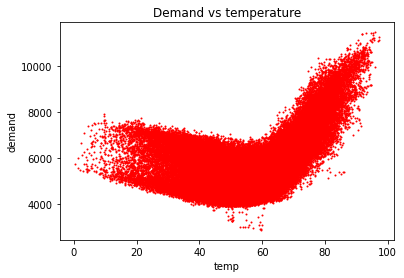

In [22]:
plt.plot(demand['temp'], demand['demand'], 'ro', markersize=1)
plt.title('Demand vs temperature')
plt.xlabel('temp')
plt.ylabel('demand')
plt.show()

The autocorrelation plot below shows the extent to which the demand variable correlates with itself at different intervals (lags). This plot shows that demand is highly autocorrelated over the closest 6 hour period.

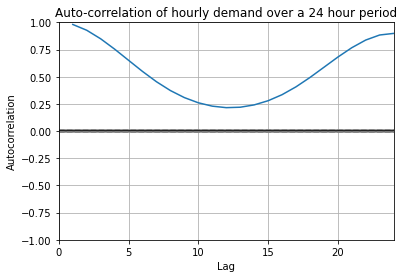

In [23]:
autocorrelation_plot(demand['demand'].dropna())
plt.xlim(0,24)
plt.title('Auto-correlation of hourly demand over a 24 hour period')
plt.show()

### Compute features for forecasting models

After exploring the data, it is clear that the energy demand follows seasonal trends, with daily, weekly and annual periodicity. We will create features that encode this information. First, we compute time driven features based on timeStamp. Note for dayofweek, Monday=0 and Sunday=6.

In [24]:
demand_features = demand.copy()

In [25]:
demand_features['hour'] = demand_features.timeStamp.dt.hour
demand_features['month'] = demand_features.timeStamp.dt.month-1
demand_features['dayofweek'] = demand_features.timeStamp.dt.dayofweek

Compute lagged demand features

In [26]:
def generate_lagged_features(df, var, max_lag):
    for t in range(1, max_lag+1):
        df[var+'_lag'+str(t)] = df[var].shift(t, freq='1H')

In [27]:
generate_lagged_features(demand_features, 'temp', 6)
generate_lagged_features(demand_features, 'demand', 6)

In [28]:
demand_features.head()

,timeStamp,demand,precip,temp,hour,month,dayofweek,temp_lag1,temp_lag2,temp_lag3,temp_lag4,temp_lag5,temp_lag6,demand_lag1,demand_lag2,demand_lag3,demand_lag4,demand_lag5,demand_lag6
2012-01-01 00:00:00,2012-01-01 00:00:00,4937.5,0.0,46.13,0,0,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012-01-01 01:00:00,2012-01-01 01:00:00,4752.1,0.0,45.89,1,0,6,46.13,NaN,NaN,NaN,NaN,NaN,4937.5,NaN,NaN,NaN,NaN,NaN
2012-01-01 02:00:00,2012-01-01 02:00:00,4542.6,0.0,45.04,2,0,6,45.89,46.13,NaN,NaN,NaN,NaN,4752.1,4937.5,NaN,NaN,NaN,NaN
2012-01-01 03:00:00,2012-01-01 03:00:00,4357.7,0.0,45.03,3,0,6,45.04,45.89,46.13,NaN,NaN,NaN,4542.6,4752.1,4937.5,NaN,NaN,NaN
2012-01-01 04:00:00,2012-01-01 04:00:00,4275.5,0.0,42.61,4,0,6,45.03,45.04,45.89,46.13,NaN,NaN,4357.7,4542.6,4752.1,4937.5,NaN,NaN


### Final data cleaning and write out training and test datasets

Count remaining null values.

In [29]:
demand_features.isnull().sum()

timeStamp       0
demand         43
precip          0
temp           86
hour            0
month           0
dayofweek       0
temp_lag1      87
temp_lag2      88
temp_lag3      89
temp_lag4      90
temp_lag5      91
temp_lag6      92
demand_lag1    43
demand_lag2    43
demand_lag3    43
demand_lag4    43
demand_lag5    43
demand_lag6    43
dtype: int64

Count number of rows with any null values

In [30]:
demand_features.loc[demand_features.isnull().any(axis=1), ].shape[0]

153

This is a very small proportion of the overall dataset so can be safely dropped.

In [31]:
demand_features.dropna(how='any', inplace=True)

In [32]:
demand_features.to_csv(os.path.join(DATADIR, 'nyc_demand_processed.csv'), index=False)

Split data into training and test datasets. All data after 1st July 2016 is reserved for the test set.

In [33]:
train, test = (demand_features.loc[demand_features['timeStamp']<'2016-07-01'], demand_features.loc[demand_features['timeStamp']>='2016-07-01'])
train.to_csv(os.path.join(DATADIR, 'nyc_demand_train.csv'), float_format='%.4f', index=False)
test.to_csv(os.path.join(DATADIR, 'nyc_demand_test.csv'), float_format='%.4f', index=False)

### Register datasets to the workspace

In [2]:
# get the workspace from config.json
ws = Workspace.from_config()
# get the datastore to upload our data
datastore = ws.get_default_datastore()

In [17]:
datastore.upload(src_dir='datasets', target_path='data')

Uploading an estimated of 5 files
Target already exists. Skipping upload for data\nyc_demand_processed.csv
Target already exists. Skipping upload for data\nyc_demand_raw.csv
Target already exists. Skipping upload for data\nyc_demand_test.csv
Target already exists. Skipping upload for data\nyc_demand_train.csv
Target already exists. Skipping upload for data\nyc_weather_raw.csv
Uploaded 0 files


$AZUREML_DATAREFERENCE_1e17c541e809468282c455fb43b09465

In [3]:
processed_dataset = Dataset.Tabular.from_delimited_files(datastore.path('data/nyc_demand_processed.csv'))

In [4]:
# preview the first 3 rows of the dataset from datastore
processed_dataset.take(3).to_pandas_dataframe()

c:\Users\madmin\Documents\XDocs\Data Science\Github_repos\bootcamp-bringing-ML-models-into-production-intermediary-jun-aug2021\bootcamp\lesson2\.venv\lib\site-packages\azureml\dataprep\api\_dataframereader.py:172: UserWarning: Please install pyarrow>=0.16.0 for improved performance of to_pandas_dataframe. You can ensure the correct version is installed by running: pip install pyarrow>=0.16.0 --upgrade
  warnings.warn('Please install pyarrow>=0.16.0 for improved performance of to_pandas_dataframe. '


,timeStamp,demand,precip,temp,hour,month,dayofweek,temp_lag1,temp_lag2,temp_lag3,temp_lag4,temp_lag5,temp_lag6,demand_lag1,demand_lag2,demand_lag3,demand_lag4,demand_lag5,demand_lag6
0,2012-01-01 06:00:00,4324.9,0.0,38.78,6,0,6,39.02,42.61,45.03,45.04,45.89,46.13,4274.7,4275.5,4357.7,4542.6,4752.1,4937.5
1,2012-01-01 07:00:00,4350.0,0.0,42.74,7,0,6,38.78,39.02,42.61,45.03,45.04,45.89,4324.9,4274.7,4275.5,4357.7,4542.6,4752.1
2,2012-01-01 08:00:00,4480.9,0.0,38.90,8,0,6,42.74,38.78,39.02,42.61,45.03,45.04,4350.0,4324.9,4274.7,4275.5,4357.7,4542.6


In [5]:
processed_ds = processed_dataset.register(workspace=ws, name="processed_nyc_demand_data", description="processed New York energy demand data")

In [6]:
train_dataset = Dataset.Tabular.from_delimited_files(datastore.path('data/nyc_demand_train.csv'))
test_dataset = Dataset.Tabular.from_delimited_files(datastore.path('data/nyc_demand_test.csv'))

In [7]:
train_dataset.take(3).to_pandas_dataframe()

c:\Users\madmin\Documents\XDocs\Data Science\Github_repos\bootcamp-bringing-ML-models-into-production-intermediary-jun-aug2021\bootcamp\lesson2\.venv\lib\site-packages\azureml\dataprep\api\_dataframereader.py:172: UserWarning: Please install pyarrow>=0.16.0 for improved performance of to_pandas_dataframe. You can ensure the correct version is installed by running: pip install pyarrow>=0.16.0 --upgrade
  warnings.warn('Please install pyarrow>=0.16.0 for improved performance of to_pandas_dataframe. '


,timeStamp,demand,precip,temp,hour,month,dayofweek,temp_lag1,temp_lag2,temp_lag3,temp_lag4,temp_lag5,temp_lag6,demand_lag1,demand_lag2,demand_lag3,demand_lag4,demand_lag5,demand_lag6
0,2012-01-01 06:00:00,4324.9,0.0,38.78,6,0,6,39.02,42.61,45.03,45.04,45.89,46.13,4274.7,4275.5,4357.7,4542.6,4752.1,4937.5
1,2012-01-01 07:00:00,4350.0,0.0,42.74,7,0,6,38.78,39.02,42.61,45.03,45.04,45.89,4324.9,4274.7,4275.5,4357.7,4542.6,4752.1
2,2012-01-01 08:00:00,4480.9,0.0,38.90,8,0,6,42.74,38.78,39.02,42.61,45.03,45.04,4350.0,4324.9,4274.7,4275.5,4357.7,4542.6


In [8]:
test_dataset.take(3).to_pandas_dataframe()

c:\Users\madmin\Documents\XDocs\Data Science\Github_repos\bootcamp-bringing-ML-models-into-production-intermediary-jun-aug2021\bootcamp\lesson2\.venv\lib\site-packages\azureml\dataprep\api\_dataframereader.py:172: UserWarning: Please install pyarrow>=0.16.0 for improved performance of to_pandas_dataframe. You can ensure the correct version is installed by running: pip install pyarrow>=0.16.0 --upgrade
  warnings.warn('Please install pyarrow>=0.16.0 for improved performance of to_pandas_dataframe. '


,timeStamp,demand,precip,temp,hour,month,dayofweek,temp_lag1,temp_lag2,temp_lag3,temp_lag4,temp_lag5,temp_lag6,demand_lag1,demand_lag2,demand_lag3,demand_lag4,demand_lag5,demand_lag6
0,2016-07-01 00:00:00,6444.750,0.0,74.63,0,6,4,75.10,75.72,76.72,75.85,77.36,80.92,6912.700,7332.625,7576.558,7603.008,7788.292,8102.142
1,2016-07-01 01:00:00,6083.075,0.0,73.77,1,6,4,74.63,75.10,75.72,76.72,75.85,77.36,6444.750,6912.700,7332.625,7576.558,7603.008,7788.292
2,2016-07-01 02:00:00,5795.317,0.0,72.32,2,6,4,73.77,74.63,75.10,75.72,76.72,75.85,6083.075,6444.750,6912.700,7332.625,7576.558,7603.008


In [9]:
train_ds = train_dataset.register(workspace=ws, name="train_nyc_demand_data", description="processed New York energy demand data for training")
test_ds = test_dataset.register(workspace=ws, name="test_nyc_demand_data", description="processed New York energy demand data for testing")